In this notebook, we're going to go through how we built the decision tree model for the dataset. 

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix



In [2]:
model_data_cleaned = pd.read_excel("model_data_cleaned.xlsx")

df = model_data_cleaned.copy()

X = df.drop(columns=["target_default_30"])
y = df["target_default_30"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

Again, we need to convert the columns using onehot encoding (logic behind this found in model_logistic)

In [6]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

categorical_cols

['Declared_accommodation_type']

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

Then we simply train the model 

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)

classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_processed, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [11]:
X_test_processed = preprocessor.transform(X_test)

y_pred = classifier.predict(X_test_processed)
y_proba = classifier.predict_proba(X_test_processed)[:, 1]  

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[516  15]
 [ 11   9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       531
           1       0.38      0.45      0.41        20

    accuracy                           0.95       551
   macro avg       0.68      0.71      0.69       551
weighted avg       0.96      0.95      0.95       551

ROC AUC: 0.7108757062146892


Here, the model is likely overfitting since precision and recall are both very bad for the default (1) class. The ROC AUC curve is better than 0.5, but still far from ~.9, so it's likely this model can be improved. 

Additionally, inspecting the decison tree below, we can see that it's depth is quite large, and therefore likely overfitting and not generalizing well. 

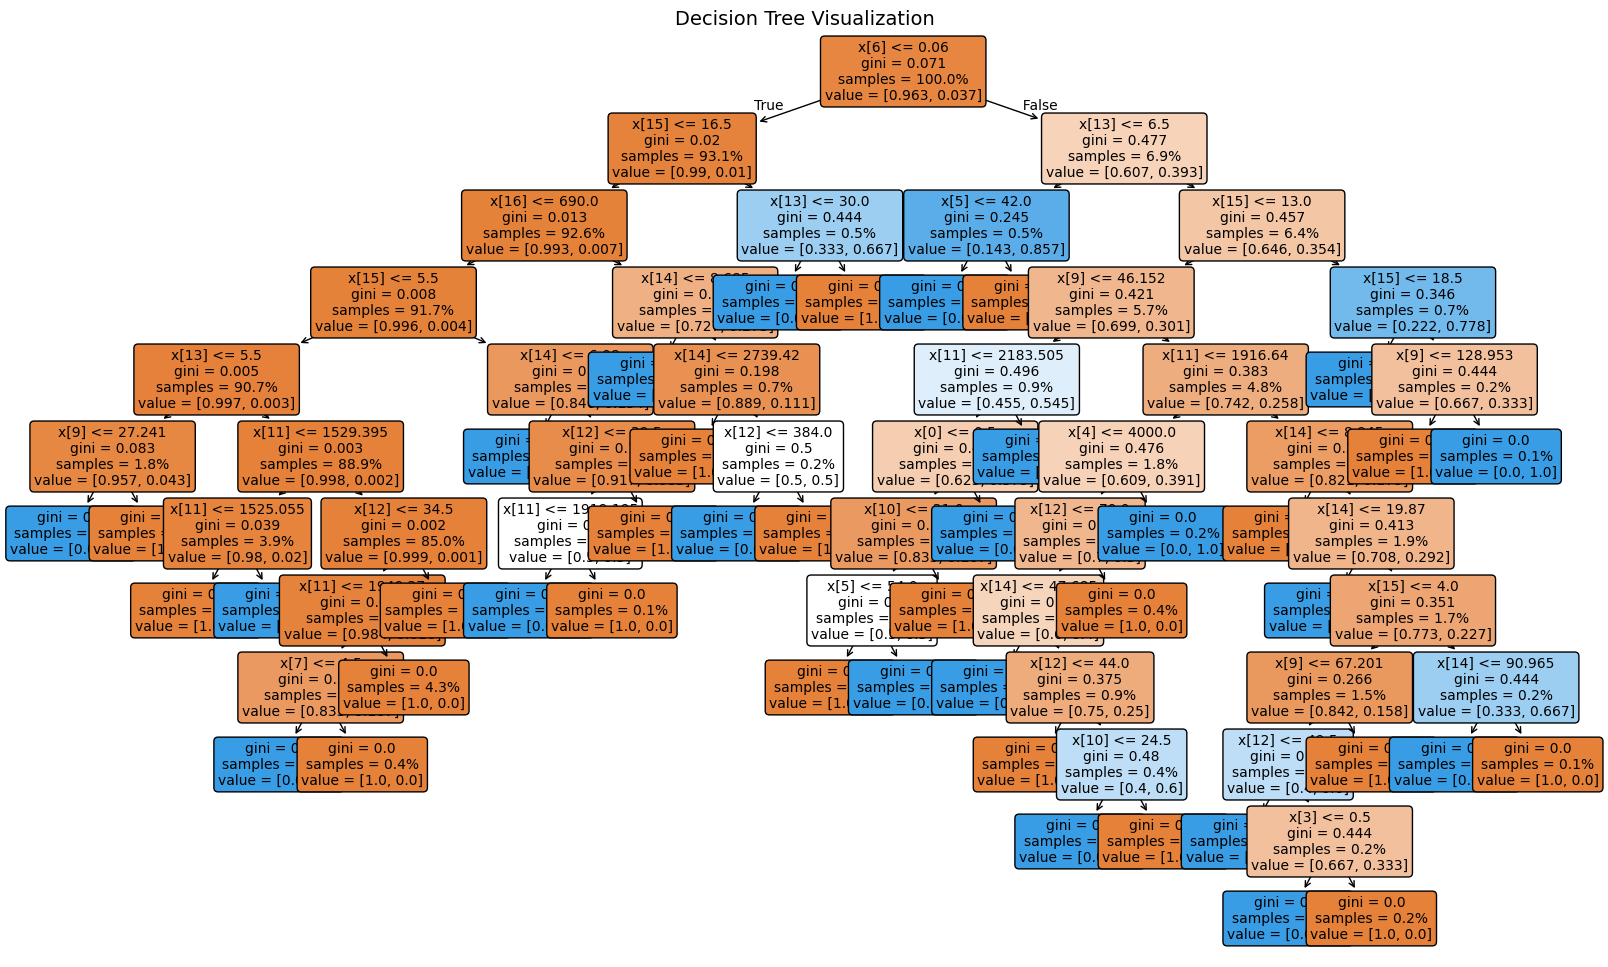

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plot_tree(classifier, 
          filled=True, 
          rounded=True,
          proportion=True,
          fontsize=10)
plt.title("Decision Tree Visualization", fontsize=14)
plt.show()

So what we can do is fine tune the model. Additonally, we're going to use a grid search to be more thorough. 


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],     
    'max_features': ['sqrt', 'log2', None],  
    'criterion': ['gini']  
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='precision') # Note we're using precision here
                                                                            # since it will help the most against overfitting
                                                                            
grid_search.fit(X_train_processed, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini'], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [28]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation Precision: ", grid_search.best_score_)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_processed)

Best parameters found:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation Precision:  0.78


In [29]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[528   3]
 [ 17   3]]

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.994     0.981       531
           1      0.500     0.150     0.231        20

    accuracy                          0.964       551
   macro avg      0.734     0.572     0.606       551
weighted avg      0.952     0.964     0.954       551

ROC-AUC Score: 0.7108757062146892


It looks like this new model is overfitting much more. If we instead try to use recall as our scoring technique, we may get better results:

In [33]:
param_grid = {
    'max_depth': [3, 5, 7, 10],  
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],     
    'max_features': ['sqrt', 'log2', None],  
    'criterion': ['gini']  
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='recall') 
                                                                            
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini'], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [34]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation Precision: ", grid_search.best_score_)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_processed)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation Precision:  0.4488888888888889


In [35]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[515  16]
 [ 11   9]]

Classification Report:
              precision    recall  f1-score   support

           0      0.979     0.970     0.974       531
           1      0.360     0.450     0.400        20

    accuracy                          0.951       551
   macro avg      0.670     0.710     0.687       551
weighted avg      0.957     0.951     0.954       551

ROC-AUC Score: 0.7108757062146892


This is much better. We can see that while precision has decreased, recall has increased dramatically. This is also good since the recall is the one we want to be maximising since we want to catch as many defaults as possible, even if that means incorrect defaults. 

However, it's likely that our model is still overfitting, since the depth of this model compared to the previous one is much larger. 

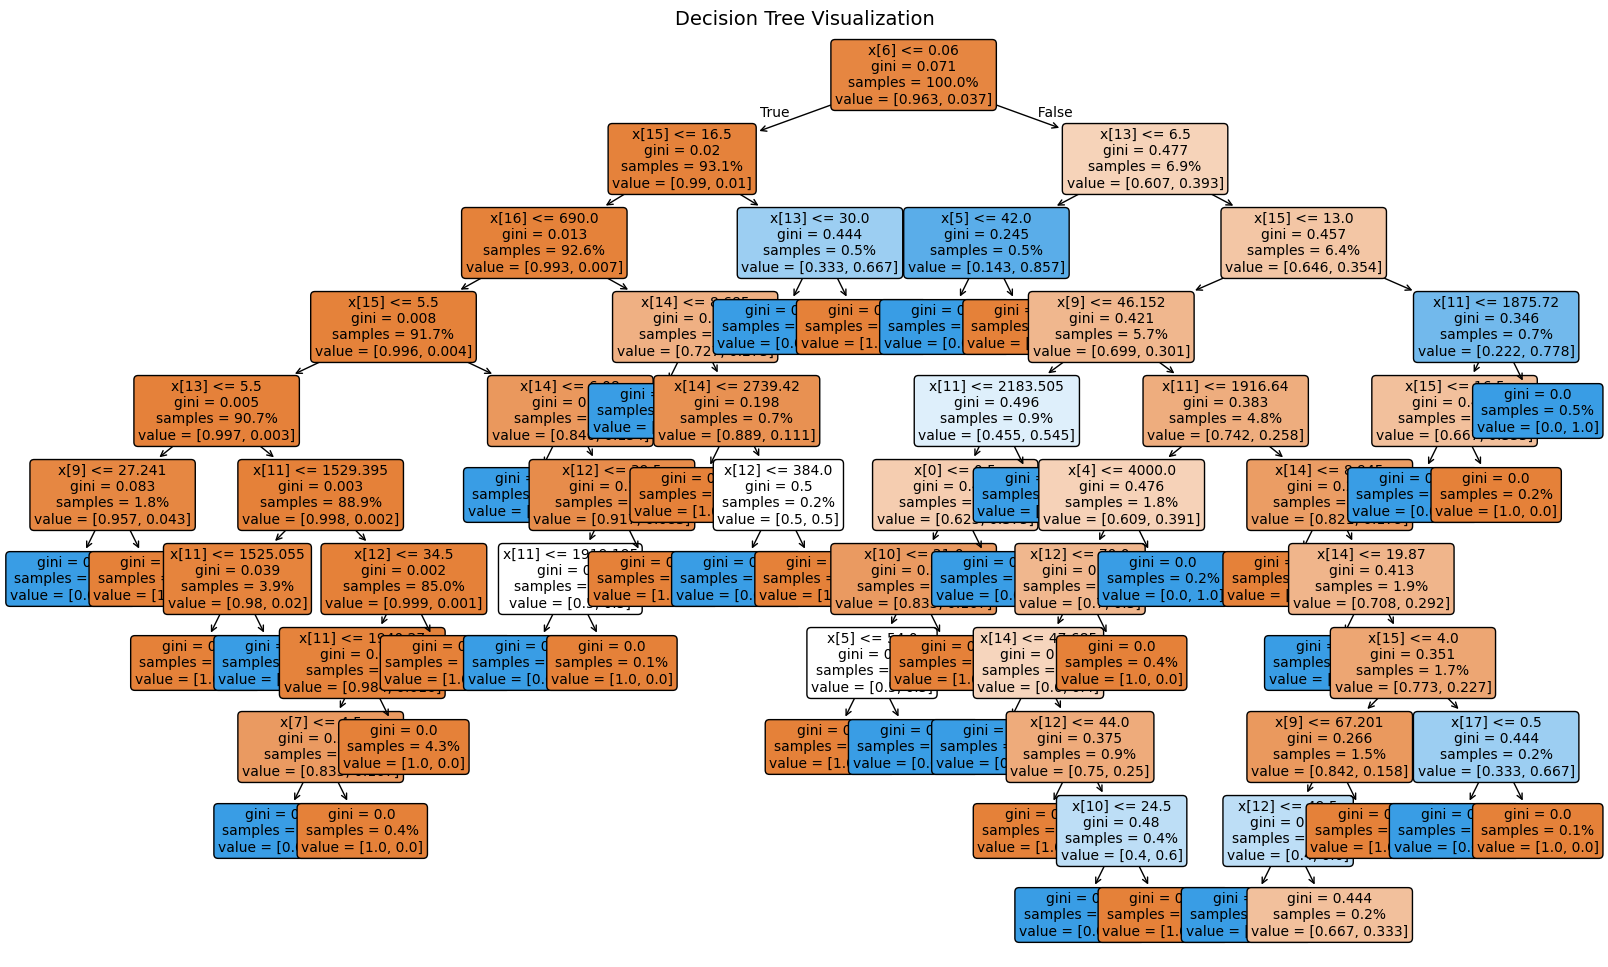

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree = grid_search.best_estimator_

plt.figure(figsize=(20, 12))
plot_tree(best_tree, 
          filled=True, 
          rounded=True,
          proportion=True,
          fontsize=10)
plt.title("Decision Tree Visualization", fontsize=14)
plt.show()

We can try to improve this model, by adding extra parameters to the grid search: 

In [37]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],               
    'min_samples_split': [2, 5, 10, 20, 50],     
    'min_samples_leaf': [1, 2, 5, 10, 20],       
    'max_features': ['sqrt', 'log2', None],      
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30],   
    'class_weight': [None, 'balanced']              
}
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='recall') 
                                                                            
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'class_weight': [None, 'balanced'], 'max_depth': [2, 3, ...], 'max_features': ['sqrt', 'log2', ...], 'max_leaf_nodes': [5, 10, ...], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [41]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation Recall: ", grid_search.best_score_)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_processed)

Best parameters found:  {'class_weight': 'balanced', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation Recall:  0.9577777777777777


In [39]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[422 109]
 [  0  20]]

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.795     0.886       531
           1      0.155     1.000     0.268        20

    accuracy                          0.802       551
   macro avg      0.578     0.897     0.577       551
weighted avg      0.969     0.802     0.863       551

ROC-AUC Score: 0.7108757062146892


These results are quite good, and it's surprising that the model has simplified the tree to just have a depth of 2. 

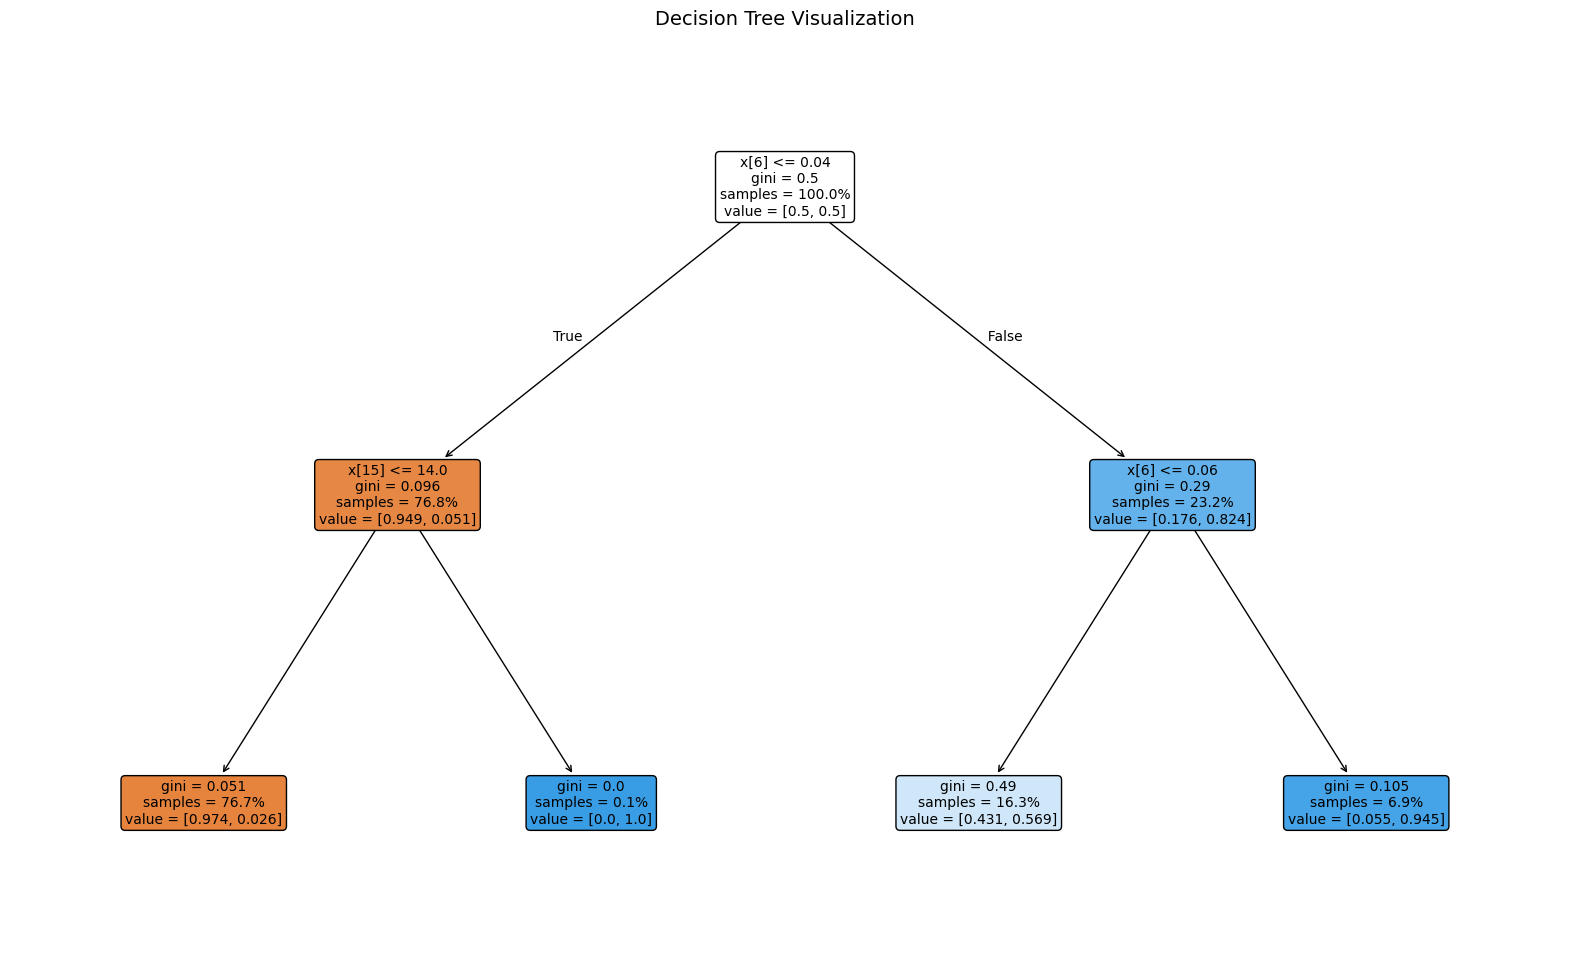

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree = grid_search.best_estimator_

plt.figure(figsize=(20, 12))
plot_tree(best_tree, 
          filled=True, 
          rounded=True,
          proportion=True,
          fontsize=10)
plt.title("Decision Tree Visualization", fontsize=14)
plt.show()

Something also good about decision trees is that they are highly interpretable, so it can be easy to show and explain how the model arrived at its decision. 

Here, we can see how the variables being split.

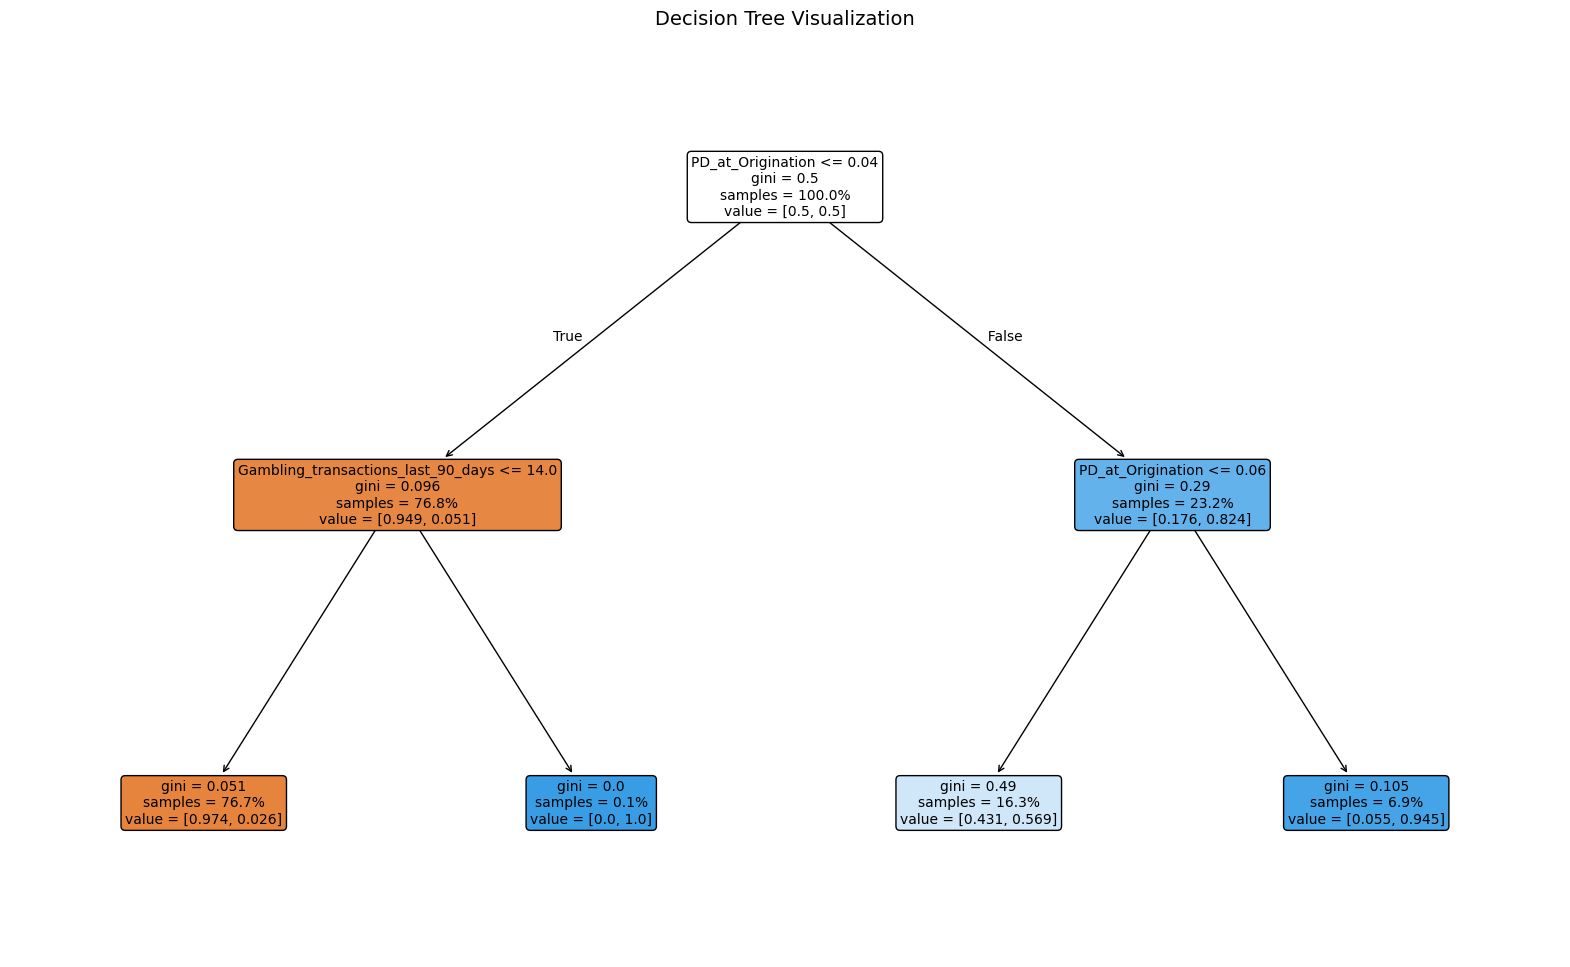

In [ ]:
import numpy as np
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

numeric_columns = [col for col in X_train.columns if col not in categorical_cols]

feature_names = np.concatenate([onehot_columns, numeric_columns])

plt.figure(figsize=(20, 12))
plot_tree(best_tree, 
          filled=True, 
          rounded=True,
          feature_names=feature_names,  
          proportion=True,
          fontsize=10)
plt.title("Decision Tree Visualization", fontsize=14)
plt.show()

In [ ]:
importances = classifier.feature_importances_

onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

numeric_columns = [col for col in X_train.columns if col not in categorical_cols]

feature_names = np.concatenate([onehot_columns, numeric_columns])

if len(feature_names) != len(importances):
    print(f"Mismatch: {len(feature_names)} features vs {len(importances)} importances")
else:

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df.head(10)) 

                               Feature  Importance
6                    PD_at_Origination    0.268645
14                Min_bal_last_30_days    0.140330
15  Gambling_transactions_last_90_days    0.138522
9                  Monthly Installment    0.082181
11                       Income to Use    0.069547
12                    Days_as_customer    0.068805
13        Transactions_in_last_30_days    0.066421
10                          Age to Use    0.033864
5                  Term_at_origination    0.029973
4                     Original_balance    0.028230


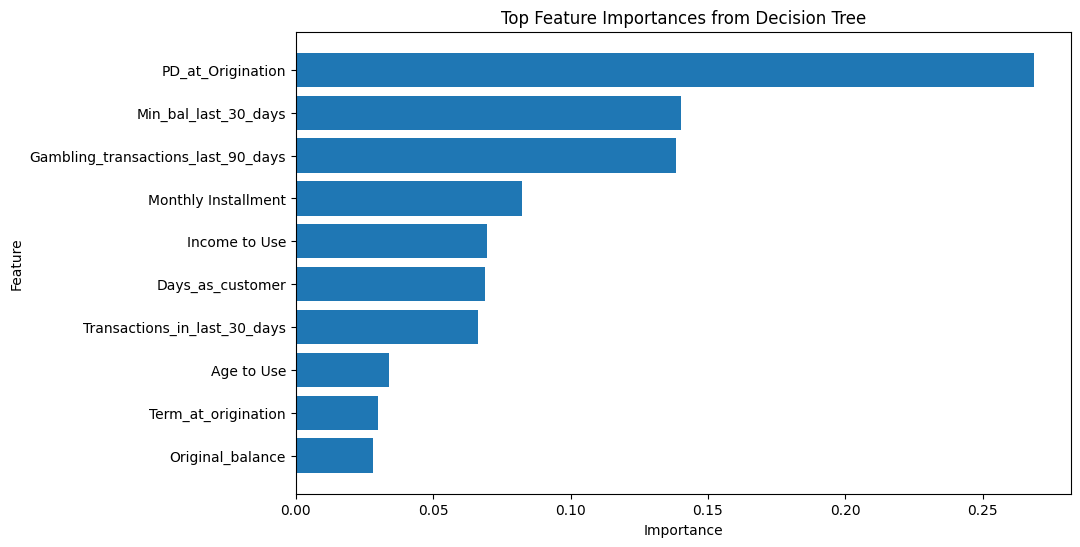

In [46]:
import matplotlib.pyplot as plt

N = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(N), feature_importance_df['Importance'].head(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances from Decision Tree')
plt.gca().invert_yaxis() 
plt.show()

**Additional fun idea**: 
You can change directly the split of the node, so if you want to see how a new policy would change the amount of loans granted you could easily change it: 

Code below is generated from chatgpt

Created generic feature names: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
Targeting feature at index 15: 'feature_15'

Found 1 nodes using 'feature_15':
Node 1: original threshold = 14.0
Node 1: new threshold = 30.0


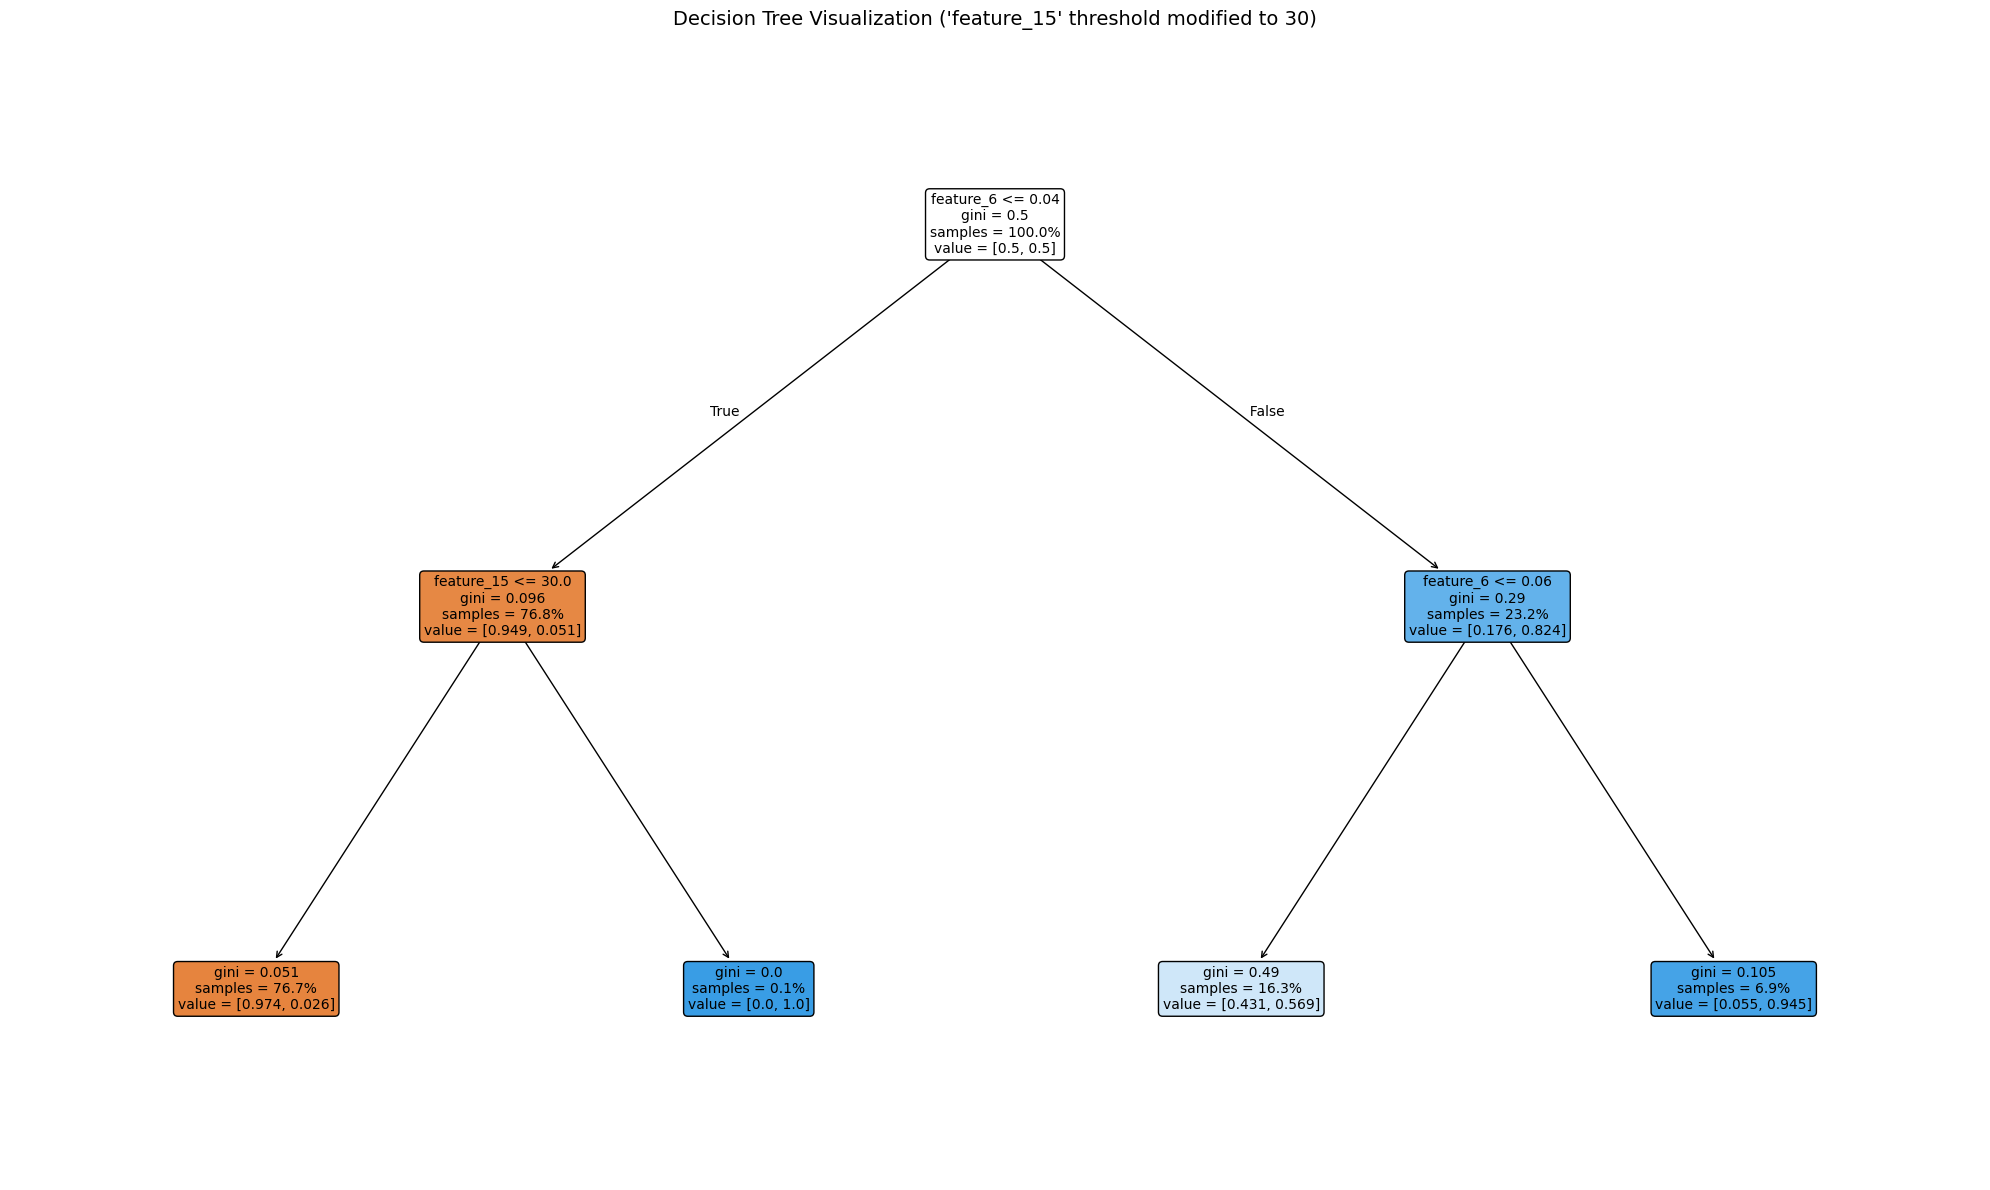

In [48]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

# Access the tree structure
tree_ = best_classifier.tree_

# Create a list of feature names that matches the model's expected features
if hasattr(best_classifier, 'feature_names_in_'):
    # Get the actual feature names the model was trained with
    feature_names = best_classifier.feature_names_in_
    print(f"Using model's stored feature names: {feature_names}")
else:
    # If model doesn't store feature names, create a generic list of the right length
    feature_names = [f"feature_{i}" for i in range(best_classifier.n_features_in_)]
    print(f"Created generic feature names: {feature_names}")

# Target feature_7 specifically
target_feature_index = 15  # This corresponds to "feature_7"
feature_name = feature_names[target_feature_index] if target_feature_index < len(feature_names) else f"feature_{target_feature_index}"
print(f"Targeting feature at index {target_feature_index}: '{feature_name}'")

# Find nodes using this feature
nodes_using_feature = [node_id for node_id in range(tree_.node_count) 
                     if tree_.feature[node_id] == target_feature_index]

if nodes_using_feature:
    print(f"\nFound {len(nodes_using_feature)} nodes using '{feature_name}':")
    for node_id in nodes_using_feature:
        original_threshold = tree_.threshold[node_id]
        print(f"Node {node_id}: original threshold = {original_threshold}")
        
        # Modify the threshold
        tree_.threshold[node_id] = 30.0
        print(f"Node {node_id}: new threshold = {tree_.threshold[node_id]}")
else:
    print(f"\nFeature '{feature_name}' is not used for splitting in this tree.")

# Plot the modified tree
plt.figure(figsize=(20, 12))
plot_tree(
    best_classifier,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    feature_names=feature_names,
    max_depth=4  # Limit depth for better visibility
)
title = "Decision Tree Visualization"
if nodes_using_feature:
    title += f" ('{feature_name}' threshold modified to 30)"
plt.title(title, fontsize=14)
plt.tight_layout()
plt.savefig('modified_decision_tree.png', dpi=300)
plt.show()